In [3]:
import pandas as pd
import numpy as np


# not needed for script
import seaborn as sns 
import matplotlib.pyplot as plt 
from matplotlib.colors import LinearSegmentedColormap
import yaml

from scipy.stats import spearmanr



prefix = '/home/klawren/oak/pcqtls'

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *
from residualize import calculate_residual


In [4]:
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

tissue_ids = load_tissue_ids(config)
my_tissue_id= 'Lung'

## PC dropping
drop pcs wwith eigenvalue less than 1

In [5]:
import numpy as np
import pandas as pd
import argparse
from sklearn.decomposition import PCA
import os
import tensorqtl
import torch
from tensorqtl.core import Residualizer
from residualize import calculate_residual


def make_bed_order(df):
    # the column order matters, so rearrange columns
    cols = list(df)
    cols.insert(0, cols.pop(cols.index('#chr')))
    cols.insert(1, cols.pop(cols.index('start')))
    cols.insert(2, cols.pop(cols.index('end')))
    cols.insert(3, cols.pop(cols.index('gene_id')))
    df = df.loc[:, cols]
    return df


In [6]:
cluster_path = config['clusters_dir'] + f'{my_tissue_id}_clusters_all_chr.csv'
expression_path = config['filtered_expression_output_dir'] + f'{my_tissue_id}.v8.normalized_residualized_expression.cluster_genes.bed'
covariates_path = config['covariates_dir'] + f'{my_tissue_id}.v8.covariates.txt'


In [7]:
   
    # load in data
    cluster_df = pd.read_csv(cluster_path)
    # expression is already residualized
    expression_df = pd.read_csv(expression_path, sep='\t')
    covariates_df = pd.read_csv(covariates_path, sep='\t', index_col=0).T

    # pull out sample ids
    sample_ids = expression_df.columns[4:]


    # add .bed info to cluster
    expression_df['egene_id'] = expression_df['gene_id'].str.split('_e_').str[1]
    expression_df['cluster_id'] = expression_df['gene_id'].str.split('_e_').str[0]
    expression_df_gid = expression_df.set_index('egene_id')

In [8]:
var_list=[]

In [9]:
cluster_pcs_dfs = []
for idx, row in cluster_df.iterrows():
        # cluster id
        cluster_id = '_'.join([*sorted(row['Transcripts'].split(','))])

        # get the gene expresion for genes in this cluster
        cluster_expression_df_gid = expression_df_gid[expression_df_gid['cluster_id']==cluster_id]
        cluster = cluster_expression_df_gid.loc[row['Transcripts'].split(',')]
        X = cluster[sample_ids].transpose()
        pca = PCA()
        pc_values = pca.fit_transform(X)

        var_list.append(pca.explained_variance_)


<AxesSubplot: ylabel='Count'>

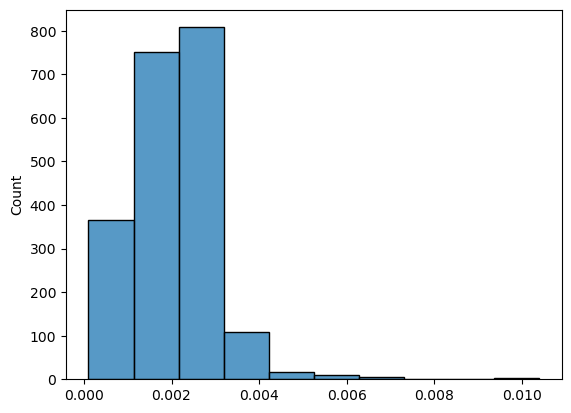

In [14]:
sns.histplot(np.concatenate(var_list), bins=10)

In [36]:
pca.explained_variance_

array([0.00271322, 0.00117783])

In [ ]:





        # get an id for each pc
        gene_ids = []
        for pc_num in range(pc_values.shape[1]):
            gene_ids.append('_'.join([*sorted(row['Transcripts'].split(',')), f'pc{pc_num+1}']))

        # center normalized and residualize the pcs
        normed_residualized_pcs = calculate_residual(pd.DataFrame(pc_values.T, columns = sample_ids), covariates_df, center=True)

        # make a dataframe of the pcs for this cluster
        cluster_pcs_df = pd.DataFrame(normed_residualized_pcs, 
                    columns = sample_ids, 
                    index = gene_ids)


        # make the gene id index a column
        cluster_pcs_df = cluster_pcs_df.reset_index().rename(columns={'index': 'gene_id'})
        cluster_pcs_df['start'] = cluster['start'].min()
        cluster_pcs_df['end'] = cluster['end'].max()
        cluster_pcs_df['#chr'] = cluster['#chr'].iloc[0]
        # make the right order for bed
        cluster_pcs_dfs.append(make_bed_order(cluster_pcs_df))

    # sorting required by tensorqtl
    cluster_pcs_df = pd.concat(cluster_pcs_dfs)
    cluster_pcs_df = cluster_pcs_df.sort_values(['#chr', 'start', 'end'])

    # occasionally we get inf for all teh values in a row.
    # Drop these as they cause susie to error
    cluster_pcs_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    print('Dropped {} rows due to inf'.format(sum(cluster_pcs_df.isna().sum(axis=1) > 0)))
    cluster_pcs_df.dropna(inplace=True)

    # write out bed pc file
    if verb:
        print('Writing out to {}'.format(pc_out_path))
    #cluster_pcs_df.to_csv(pc_out_path, sep='\t', index=False)

In [24]:
pc_bed(cluster_path, expression_path, covariates_path, 'output/test', verb=1)

loading data


KeyboardInterrupt: 

## call clusters
inputs

        * normalized_expression
        * full_covariates

#### for protein coding, make an exprssion df that's just protein coding genes

In [13]:
tissue_df = pd.read_csv('/home/klawren/oak/pcqtls/data/references/selected_tissue_ids.csv')
tissue_ids = list(tissue_df['Tissue'])


In [8]:
# load in the gene information (start and strand are what I need)
full_gencode=pd.read_csv('/home/klawren/oak/pcqtls/data/references/processed_gencode.v26.GRCh38.genes.gtf', sep='\t', skiprows=range(6), 
            header=None, names=['chr', 'dataset', 'type', 'start','end', '.', 'strand', 'na', 'info'])

full_gencode = full_gencode[full_gencode['type']=='transcript']
full_gencode['transcript_id'] = full_gencode['info'].str.split(';').str[1].str.split('\"').str[-2]
full_gencode['gene_type'] = full_gencode['info'].str.split(';').str[2].str.split('\"').str[-2]


# add in the start and end info
full_gencode['tss_start'] = np.where(full_gencode['strand'] == '+', full_gencode['start'], full_gencode['end'])
full_gencode['gene_end'] = np.where(full_gencode['strand'] == '-', full_gencode['start'], full_gencode['end'])

full_gencode = full_gencode[full_gencode['gene_type'] == 'protein_coding']

In [15]:
for tissue_id in tissue_ids:
    # load in expression
    print(tissue_id)
    expression_path = f'/home/klawren/oak/pcqtls/data/processed/normalized_expression_tami/{tissue_id}.v8.normalized_expression.bed'
    expression_df = pd.read_csv(expression_path, sep='\t')
    # filter to just protein coding genes
    proteincoding_expression_df = expression_df[expression_df['gene_id'].isin(full_gencode['transcript_id'])]
    # write out
    proteincoding_expression_df.to_csv(f'/home/klawren/oak/pcqtls/data/processed/normalized_expression_proteincoding/{tissue_id}.v8.normalized_expression.bed', sep='\t', index=None)

Adipose_Subcutaneous
Adipose_Visceral_Omentum
Artery_Tibial
Cells_Cultured_fibroblasts
Esophagus_Mucosa
Esophagus_Muscularis
Lung
Muscle_Skeletal
Nerve_Tibial
Skin_Not_Sun_Exposed_Suprapubic
Skin_Sun_Exposed_Lower_leg
Thyroid
Whole_Blood


#### draft for cluster calling

In [2]:
expression_path = '/home/klawren/oak/pcqtls/data/processed/normalized_expression_tami/Adipose_Subcutaneous.v8.normalized_expression.bed'
covariates_path = '/home/klawren/oak/pcqtls/data/processed/covariates_tami/Adipose_Subcutaneous.v8.covariates.txt'
tissue_id = 'test'
#call_clusters.get_clusters(expression_path, covariates_path, tissue_id)

In [3]:
# params
max_cluster_size=50
min_cluster_size=2

# what counts as correlated?
# I think this was 0 in tamis
# seems to be looking for sum(is.na(tmp))
# see for example, this cluster: 4,2,"ENSG00000140157.14,ENSG00000273749.4","NIPA2, CYFIP1",100.0,0.086,0.086,,15,Adipose_Subcutaneous
min_corr_cuntoff = .1

# how many pairs have to have abs(pair_corr) above the min_corr_cuntoff value
percent_corr_cutoff=.7

tissue_id = 'Adipose_Subcutaneous'

In [4]:
# load in data
expression_df = pd.read_csv('/home/klawren/oak/pcqtls/data/processed/normalized_expression_tami/Adipose_Subcutaneous.v8.normalized_expression.bed', sep='\t')
expression_df

,#chr,start,end,gene_id,GTEX-1117F,GTEX-111CU,GTEX-111FC,GTEX-111VG,GTEX-111YS,GTEX-1122O,...,GTEX-ZXES,GTEX-ZXG5,GTEX-ZYFC,GTEX-ZYFD,GTEX-ZYT6,GTEX-ZYVF,GTEX-ZYW4,GTEX-ZYY3,GTEX-ZZ64,GTEX-ZZPU
0,chr1,29552,29553,ENSG00000227232.5,1.313533,-0.900794,-0.292690,-0.732411,-0.274754,-0.699026,...,-0.347092,0.527368,1.976396,1.776799,-0.324309,-0.894351,-2.256250,0.279229,0.421295,-1.423335
1,chr1,135894,135895,ENSG00000268903.1,-0.397876,0.572460,-1.091816,2.115771,0.103551,0.129569,...,-0.666401,-0.850245,-1.447466,1.038647,-1.303395,-0.347092,0.234711,1.423335,-0.856443,1.002398
2,chr1,137964,137965,ENSG00000269981.1,0.060333,0.995306,-0.844079,2.314897,0.618748,0.704535,...,0.077602,-1.046061,-1.776799,-1.115573,-0.807734,0.488170,0.283710,1.630041,-1.084032,1.226711
3,chr1,173861,173862,ENSG00000241860.6,0.225866,-0.819728,-0.234711,1.068659,0.261361,1.123634,...,2.204469,-1.366375,-1.553621,-1.698852,-0.532324,-0.310720,0.449708,0.239141,-1.313533,0.819728
4,chr1,195410,195411,ENSG00000279457.4,0.292690,-1.002398,0.402542,-0.542275,-1.776799,-0.552281,...,0.297188,1.447466,-1.156632,2.256250,0.582637,-0.195041,0.655684,0.623972,0.572460,-0.894351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24660,chrX,155669943,155669944,ENSG00000185973.10,-1.400004,0.168768,-0.297188,-0.012921,0.195041,-0.981268,...,1.182233,-1.254606,-0.034462,-1.156632,0.342521,-0.021536,0.351670,-2.256250,0.715619,-0.081923
24661,chrX,155767811,155767812,ENSG00000168939.11,-2.204469,-0.043083,-0.749413,-0.900794,1.568183,1.498434,...,1.313533,-0.030153,1.377412,-0.618748,-0.721194,0.017229,-1.798076,0.190653,0.324309,1.165081
24662,chrX,155881292,155881293,ENSG00000124333.15,-0.073283,-0.043083,0.203828,-0.507671,0.704535,-0.650353,...,0.051706,-0.416593,0.946992,0.900794,-1.598348,-0.265820,0.807734,-0.933590,1.148265,1.798076
24663,chrX,155997580,155997581,ENSG00000124334.17,0.940270,-1.148265,-0.407217,1.273758,-1.148265,-0.444948,...,0.738055,-0.221450,-1.148265,-1.148265,-0.645041,1.919012,-1.148265,-0.542275,-0.064649,-0.116550


In [5]:
covariates_df = pd.read_csv('/home/klawren/oak/pcqtls/data/processed/covariates_tami/Adipose_Subcutaneous.v8.covariates.txt', sep='\t', index_col=0).T
covariates_df

ID,PC1,PC2,PC3,PC4,PC5,InferredCov1,InferredCov2,InferredCov3,InferredCov4,InferredCov5,...,InferredCov54,InferredCov55,InferredCov56,InferredCov57,InferredCov58,InferredCov59,InferredCov60,pcr,platform,sex
GTEX-1117F,-0.0867,-0.0132,-0.0062,0.0046,0.0054,0.020909,0.018987,0.034279,-0.004583,0.100213,...,0.028558,-0.108875,-0.135383,-0.062187,0.073324,0.022494,0.009804,1.0,1.0,2.0
GTEX-111CU,0.0107,-0.0026,0.0004,-0.0015,0.0112,-0.020838,-0.024584,0.017718,-0.024737,-0.020060,...,0.019939,0.010496,0.126874,0.168892,-0.108860,0.063715,-0.016651,1.0,1.0,1.0
GTEX-111FC,0.0099,-0.0050,0.0304,0.0076,0.0347,0.043041,-0.014273,0.015329,0.033659,-0.036465,...,0.055394,0.007636,-0.046512,-0.111226,-0.172059,-0.116399,0.210148,1.0,1.0,1.0
GTEX-111VG,0.0144,-0.0081,0.0133,0.0035,0.0018,0.027753,-0.033660,0.007306,-0.087757,0.031649,...,0.094220,-0.057693,-0.073819,0.017391,0.076359,-0.007445,-0.109115,1.0,1.0,1.0
GTEX-111YS,0.0154,-0.0093,0.0107,-0.0038,-0.0083,-0.020914,0.017681,-0.040232,0.010476,0.019253,...,-0.021506,0.089417,0.124951,-0.104352,0.192588,-0.128535,0.009471,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTEX-ZYVF,0.0118,0.0005,-0.0678,0.0063,0.0326,-0.019215,0.029521,0.048050,-0.088771,-0.017989,...,-0.057573,0.027613,0.217577,0.083199,0.456139,0.011376,0.063828,1.0,1.0,2.0
GTEX-ZYW4,-0.0245,0.2918,0.0227,0.1210,0.0376,0.013738,0.033801,0.037867,0.010357,0.065015,...,0.018522,0.027766,-0.084631,-0.076807,0.035903,-0.021350,0.066904,1.0,1.0,1.0
GTEX-ZYY3,0.0111,-0.0048,-0.0795,-0.0113,0.0100,-0.024992,0.009624,-0.014019,-0.033134,0.054995,...,-0.086990,0.072295,0.012627,-0.193751,-0.103690,0.080859,0.112726,1.0,1.0,2.0
GTEX-ZZ64,0.0137,-0.0048,0.0171,-0.0016,-0.0138,-0.049920,0.004585,-0.007352,0.044326,-0.005257,...,0.098307,-0.034423,-0.094158,0.135274,0.035642,-0.049776,0.055648,1.0,1.0,1.0


In [6]:
# residulize the expression 
residal_exp = calculate_residual(expression_df[covariates_df.index], covariates_df, center=True)
residal_exp = pd.DataFrame(residal_exp, columns=covariates_df.index, index=expression_df['gene_id'])
residal_exp

,GTEX-1117F,GTEX-111CU,GTEX-111FC,GTEX-111VG,GTEX-111YS,GTEX-1122O,GTEX-1128S,GTEX-113IC,GTEX-117YX,GTEX-11DXX,...,GTEX-ZXES,GTEX-ZXG5,GTEX-ZYFC,GTEX-ZYFD,GTEX-ZYT6,GTEX-ZYVF,GTEX-ZYW4,GTEX-ZYY3,GTEX-ZZ64,GTEX-ZZPU
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000227232.5,-0.010920,-0.005368,0.019930,0.007208,-0.021872,-0.053110,0.026491,0.017894,0.000386,-0.016673,...,-0.040284,0.072284,0.043416,0.036225,0.047466,-0.035930,-0.035219,-0.003375,0.048670,-0.039268
ENSG00000268903.1,-0.063248,0.030975,0.020710,-0.018623,-0.000728,-0.004470,0.052737,-0.089720,-0.038031,0.048589,...,-0.026074,-0.020204,-0.038054,0.001629,-0.005612,-0.078953,0.002072,0.019109,0.038606,0.083183
ENSG00000269981.1,-0.043514,0.028810,0.019220,-0.023095,0.022431,0.023407,0.038640,-0.151575,-0.066462,0.028538,...,0.001899,-0.029136,-0.045878,-0.050813,0.010719,-0.043997,0.003071,0.036357,0.014159,0.086613
ENSG00000241860.6,-0.002676,-0.043455,-0.016773,0.010214,0.000047,0.068849,0.052208,-0.073213,0.000541,0.016522,...,0.053892,-0.047327,-0.043257,-0.024338,-0.019272,0.031975,0.004621,-0.012527,-0.077464,0.011767
ENSG00000279457.4,0.029146,-0.026367,0.017061,-0.025151,-0.085430,-0.024145,0.012957,-0.105733,-0.020436,0.003320,...,0.010234,0.048648,-0.004212,0.052239,0.018816,-0.031402,-0.000531,0.011266,0.020266,-0.014226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000185973.10,0.007483,0.016540,-0.028145,0.019946,0.067194,-0.030645,0.015682,-0.058199,0.001595,0.035278,...,-0.017165,-0.037817,0.005412,0.013024,-0.032811,0.003636,0.017173,-0.024915,-0.033566,0.024520
ENSG00000168939.11,-0.013789,-0.019065,-0.030895,-0.001510,-0.020426,0.020647,-0.021603,-0.040575,0.072211,-0.033797,...,0.002112,-0.023358,0.024843,0.070415,-0.031754,0.001208,0.010806,-0.029612,-0.016043,0.010832
ENSG00000124333.15,0.024797,0.069487,0.007722,-0.007970,0.037216,-0.004854,-0.065182,0.063672,-0.039138,0.078003,...,-0.002309,0.004750,-0.019101,0.009969,-0.064806,-0.068336,0.037712,-0.046365,0.062478,0.022851


In [7]:
chr_expr = residal_exp.loc[expression_df[expression_df['#chr']=='chr21']['gene_id']]
chr_expr

,GTEX-1117F,GTEX-111CU,GTEX-111FC,GTEX-111VG,GTEX-111YS,GTEX-1122O,GTEX-1128S,GTEX-113IC,GTEX-117YX,GTEX-11DXX,...,GTEX-ZXES,GTEX-ZXG5,GTEX-ZYFC,GTEX-ZYFD,GTEX-ZYT6,GTEX-ZYVF,GTEX-ZYW4,GTEX-ZYY3,GTEX-ZZ64,GTEX-ZZPU
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000277117.4,-0.001422,-0.013365,0.023930,-0.012816,-0.004403,0.040883,-0.023673,0.052547,-0.032267,0.015691,...,-0.014684,-0.072686,0.009508,0.055364,-0.087490,0.003764,-0.013513,-0.000916,-0.034475,-0.006757
ENSG00000280071.3,0.007851,-0.004861,0.038124,0.004434,0.014927,-0.035080,0.042427,0.004199,-0.009716,0.040916,...,0.020261,0.020811,-0.031002,0.037372,0.032872,-0.055766,-0.022681,0.022376,-0.081065,0.011424
ENSG00000275464.4,-0.008202,0.003427,0.017323,0.029222,0.017492,-0.050810,0.036241,0.001129,0.008218,0.008634,...,0.010680,0.042123,-0.049530,0.051827,0.020425,-0.159953,-0.022000,0.042063,-0.047992,0.035568
ENSG00000280433.1,-0.041243,0.001903,0.025382,0.048589,-0.060244,-0.021577,0.042149,-0.037988,-0.008292,0.031055,...,0.059215,0.046193,-0.037896,0.028985,0.031494,-0.079625,-0.030647,-0.000155,-0.055980,-0.022584
ENSG00000275993.2,-0.007083,-0.009237,-0.021228,0.003182,-0.010099,0.007029,-0.058008,-0.048989,-0.002603,-0.008796,...,0.042967,-0.023888,0.022242,-0.061506,-0.012356,-0.153429,-0.004298,-0.016079,-0.031419,0.028584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000160299.16,-0.046178,0.005915,0.068763,0.067214,-0.081754,-0.002209,0.004536,0.012241,-0.004244,0.037448,...,0.017623,-0.010850,-0.026628,0.061378,0.001066,0.105522,0.004727,0.005170,-0.021243,0.054400
ENSG00000160305.17,0.130128,-0.004119,-0.050995,0.067290,0.032537,-0.015831,-0.041940,0.014604,0.026371,0.023335,...,-0.061737,-0.056543,-0.047327,0.027734,-0.034301,-0.007235,-0.021752,-0.060339,-0.025030,0.014449
ENSG00000160307.9,-0.004856,-0.012496,-0.007484,-0.011640,0.022183,0.084272,-0.004970,0.021060,-0.006229,0.068256,...,0.027630,-0.046838,0.005102,-0.059335,0.014776,0.050248,0.040665,0.043759,-0.045673,0.047187


In [10]:
# get total number of pairs included
total_pairs = 0
for i in np.arange(1,23,1):
    chr_gene_ids = expression_df[expression_df['#chr'] == f'chr{i}']['gene_id']
    upper_corner_idxs = np.triu(np.ones(len(chr_gene_ids)), k=1)
    excluded_cluster_size_idxs = np.triu(np.ones(len(chr_gene_ids)), k=max_cluster_size)
    total_pairs += upper_corner_idxs.sum()  - excluded_cluster_size_idxs.sum()

In [105]:
# get expression clusters on a per-chrom basis
def get_clusters_chr(chr_id, expression_df, residal_exp, total_pairs, tissue_id, min_cluster_size=2, max_cluster_size=50, min_corr_cutoff=.01, percent_corr_cutoff=.7, cutoff_type='pvalue'):
    # genes on this chr
    chr_gene_ids = expression_df[expression_df['#chr'] == f'chr{chr_id}']['gene_id']
    chr_residual_exp = residal_exp.loc[chr_gene_ids]

    # get correlation and pvalues
    try:
        chr_corr, chr_pvalue = spearmanr(chr_residual_exp, axis=1)
    except IndexError:
        # no genes on this chr
        return pd.DataFrame({})
    chr_corr = pd.DataFrame(chr_corr, index=chr_residual_exp.index, columns=chr_residual_exp.index)
    chr_pvalue = pd.DataFrame(chr_pvalue, index=chr_residual_exp.index, columns=chr_residual_exp.index)

    print('calcuated correlations')

    # iterate through and call the cluster
    # list of transcripts that are already in a cluster
    transcript_blacklist = []

    # list of clusters
    cluster_output = []

    for cluster_size in np.arange(max_cluster_size, min_cluster_size-1, -1):
        # total number of pairs we consizer for this cluster size 
        number_pairs = sum(sum(np.triu(np.ones((cluster_size, cluster_size)), k=1)))

        # each possible start along the genome
        for cluster_start_idx in range(0, len(chr_corr)-cluster_size):
            # pull the cluster of this size stating at this index
            
            cluster_candidate = chr_corr.iloc[cluster_start_idx:cluster_start_idx+cluster_size, cluster_start_idx:cluster_start_idx+cluster_size]
            # corr values in upper triangle
            cluster_values = cluster_candidate.values[np.triu_indices(cluster_size, k=1)]
            
            # number of corrs with abs value above cuttoff or p value below cutoff
            if cutoff_type == 'value':
                number_corrs_above_cutoff = sum(sum(abs(cluster_candidate.values)>min_corr_cutoff))
            elif cutoff_type == 'pvalue':
                # calculate p values below a bonferonni 0.05
                cluster_candidate_pvalues = chr_pvalue.iloc[cluster_start_idx:cluster_start_idx+cluster_size, cluster_start_idx:cluster_start_idx+cluster_size]
                # only take top corner 
                cluster_pvalues = cluster_candidate_pvalues.values[np.triu_indices(cluster_size, k=1)]
                # pvalues values in upper triangle less than 0.05/total number tests
                number_corrs_above_cutoff = sum(cluster_pvalues<(0.05/total_pairs))
            else:
                raise ValueError


            # transcripts
            cluster_transcripts = cluster_candidate.index.values
            # in blacklist?
            in_blacklist = sum(cluster_candidate.index.isin(transcript_blacklist))
            # percent corr
            percent_corr = number_corrs_above_cutoff/number_pairs

            # record cluster if enough pairs have higher enough abs correlation, and not recoreded before
            if (percent_corr > percent_corr_cutoff) & (in_blacklist==0):
                # this is the data on each cluster we need
                # N_genes,Transcripts,Genes,Perc_cor,Mean_cor,Mean_pos_cor,Mean_neg_cor,Chromosome,Tissue
                
                # check if the edges of the cluster count be cut off (no correlations)
                if cutoff_type=='value':
                    cluster_bool_df = cluster_candidate >min_corr_cutoff
                elif cutoff_type=='pvalue':
                    cluster_bool_df = cluster_candidate_pvalues < (0.05/total_pairs)

                # initiate the trimmed cluster as the full cluster
                trimmed_cluster = cluster_candidate
                trimmed_cluster_bool = cluster_bool_df

                # check if the first gene can be trimmed
                first_gene_inclusion = sum(cluster_bool_df.iloc[1:,0])
                # while the first gene has no correlations, trim it off
                while first_gene_inclusion == 0:
                    # make the cluster smaller
                    trimmed_cluster_bool = trimmed_cluster_bool.iloc[1:, 1:]
                    trimmed_cluster = trimmed_cluster.iloc[1:,1:]
                    # check for the inclusion again
                    first_gene_inclusion = sum(trimmed_cluster_bool.iloc[1:,0])


                last_gene_inclusion = sum(trimmed_cluster_bool.iloc[-1, :-1])
                # while the last gene has no correlations, trim it off
                while last_gene_inclusion == 0:
                    # make the cluster smaller
                    trimmed_cluster_bool = trimmed_cluster_bool.iloc[:-1, :-1]
                    trimmed_cluster = trimmed_cluster.iloc[:-1, :-1]
                    # check for the inclusion again
                    last_gene_inclusion = sum(trimmed_cluster_bool.iloc[-1, :-1])


                # update the recorded informaiton
                trimmed_cluster_size = len(trimmed_cluster)
                cluster_transcripts = trimmed_cluster.index.values
                number_corrs_above_cutoff = sum(trimmed_cluster_bool.values[np.triu_indices(trimmed_cluster_size, k=1)])
                precent_corr = number_corrs_above_cutoff/sum(sum(np.triu(np.ones((trimmed_cluster_size, trimmed_cluster_size)), k=1)))
                trimmed_cluster_values = trimmed_cluster.values[np.triu_indices(trimmed_cluster_size, k=1)]
                

                # make a pd series for output
                cluster_series = pd.Series({'N_genes':trimmed_cluster_size,
                            'Transcripts':','.join(cluster_transcripts),
                            'Perc_cor':percent_corr,
                            'Mean_cor':np.mean(cluster_values),
                            'Mean_pos_cor':np.mean(cluster_values[cluster_values>0]),
                            'Mean_neg_cor':np.mean(cluster_values[cluster_values<0]),
                            'Chromosome':chr_id,
                            'Tissue':tissue_id})
                # record cluster
                cluster_output.append(cluster_series)
                # recored transcript ids so they aren't included in another cluster
                [transcript_blacklist.append(id) for id in cluster_transcripts]

    # make one dataframe and write out
    out_df = pd.DataFrame(cluster_output)
    # smaller clusters than the minimum can sneak in through the trimming process, remove these
    out_df = out_df[out_df['N_genes'] >= min_cluster_size]
    # sort by cluster size and return 
    return out_df.sort_values('N_genes', ascending=False)

In [109]:
cluster_10 = get_clusters_chr(21, expression_df, residal_exp, total_pairs, 'test', percent_corr_cutoff=.1)
cluster_40 = get_clusters_chr(21, expression_df, residal_exp, total_pairs, 'test', percent_corr_cutoff=.4)

calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [81]:
def plot_heatmap_corr(corr, ax, cbar=True, tick_labels=False):
    # plot a heat map of correlations for increasing number of peer factors

    # mask so the off diagonal isn't shown
    mask = np.triu(np.ones_like(corr)) 
    # create the colormap, these are colors matched to the manhattenplots. coolwarm is another good option
    cmap = LinearSegmentedColormap.from_list('mycmap', [(0, '#c4553aff'), (.5, 'white'), (1, '#3e8093ff')])
    # plot the correlations
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, ax=ax, cbar_kws={'label':'Spearman Corrleation', 'pad':0}, xticklabels=True, yticklabels=True, cbar=cbar)

    if not tick_labels:
        ax.tick_params(left=False, bottom=False)
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    # no axis labels
    ax.set_ylabel('')
    ax.set_xlabel('')

    return ax

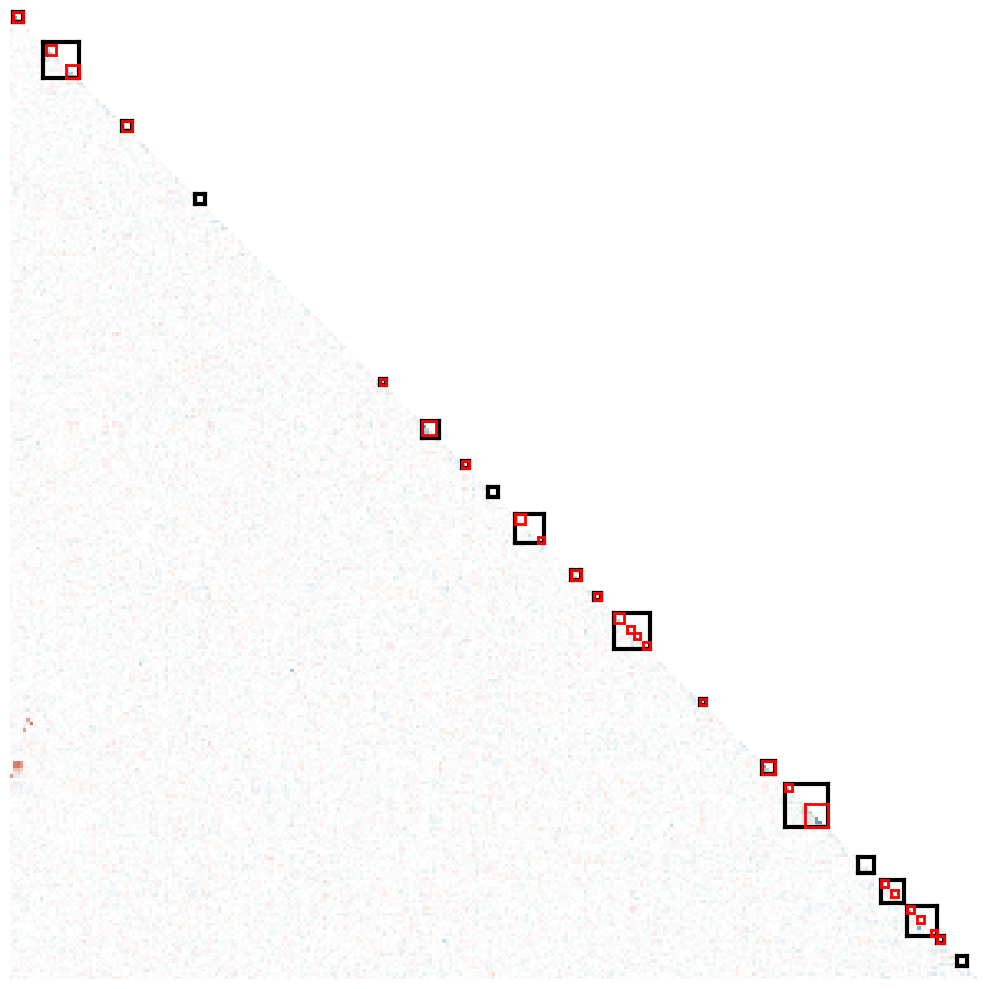

In [95]:
# correlation plots by increaseing cluster threshold
chr_reset_index = chr_residual_exp.reset_index()

fig, ax = plt.subplots(figsize=(10, 10))

plot_heatmap_corr(chr_corr, ax, cbar=True if i==10 else False)
# plot clusters at different thresholds
for idx, row in cluster_10.iterrows():
    # location of this cluster in the expression df
    cluster_idxs = chr_reset_index[chr_reset_index['gene_id'].isin(row['Transcripts'].split(','))].index.values
    # vertical line part
    ax.plot([cluster_idxs[-1]+1,cluster_idxs[-1]+1],[cluster_idxs[0],cluster_idxs[-1]+1],  color='k', linewidth=3)
    ax.plot([cluster_idxs[0],cluster_idxs[0]], [cluster_idxs[0],cluster_idxs[-1]+1], color='k', linewidth=3)
    # horizontal line part
    ax.plot([cluster_idxs[0],cluster_idxs[-1]+1], [cluster_idxs[-1]+1,cluster_idxs[-1]+1], color='k', linewidth=3)
    ax.plot([cluster_idxs[0],cluster_idxs[-1]+1], [cluster_idxs[0],cluster_idxs[0]], color='k', linewidth=3)

for idx, row in cluster_40.iterrows():
    # location of this cluster in the expression df
    cluster_idxs = chr_reset_index[chr_reset_index['gene_id'].isin(row['Transcripts'].split(','))].index.values
    # vertical line part
    ax.plot([cluster_idxs[-1]+1,cluster_idxs[-1]+1],[cluster_idxs[0],cluster_idxs[-1]+1],  color='r', linewidth=2)
    ax.plot([cluster_idxs[0],cluster_idxs[0]], [cluster_idxs[0],cluster_idxs[-1]+1], color='r', linewidth=2)
    # horizontal line part
    ax.plot([cluster_idxs[0],cluster_idxs[-1]+1], [cluster_idxs[-1]+1,cluster_idxs[-1]+1], color='r', linewidth=2)
    ax.plot([cluster_idxs[0],cluster_idxs[-1]+1], [cluster_idxs[0],cluster_idxs[0]], color='r', linewidth=2)


fig.tight_layout()
